In [ ]:
                !pip install -q transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 70.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 26.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 119.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.6 MB/s eta 0:00:00


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import json
import os
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import BertModel, BertTokenizer
import warnings
warnings.filterwarnings('ignore')
# specify GPU
device = torch.device("cuda")
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def split_text(text):
    text = text.replace('«', '')
    text = text.replace('»', '')
    text = text.replace('"', '')
    text = text.replace('-', '')

    text = text.replace('т. д.', 'т д')
    text = text.replace('т. п.', 'т п')
    text = text.replace('др.', 'др')

    text = text.replace('...,', ',')
    text = text.replace('?,', ',')
    text = text.replace('!,', ',')
    text = text.replace('.,', ',')
    text = text.replace('.)', ')')
    text = text.replace(';,', ',')

    text = text.replace('....', ';')
    text = text.replace('...', ';')
    text = text.replace('..', ';')

    text = text.replace('!', ';')
    text = text.replace('!!', ';')
    text = text.replace('!!!', ';')
    text = text.replace('?', ';')
    text = text.replace('??', ';')
    text = text.replace('???', ';')
    text = text.replace('!?', ';')
    text = text.replace('?!', ';')
    text = text.replace('.', ';')
    text = text.replace(u'\xa0', u' ')

    return [txt.strip() for txt in text.split(';')]

**Загрузка описания психологических векторов.**

In [ ]:
person_vectors = ("brown", "black", "red", "orange", "yellow", "green", "blue", "purple")

In [ ]:
label_map = dict(zip(person_vectors, [vectorId for vectorId in range(len(person_vectors))]))
print(label_map)
id2label = dict(zip([vectorId for vectorId in range(len(person_vectors))], person_vectors))
print(id2label)

{'brown': 0, 'black': 1, 'red': 2, 'orange': 3, 'yellow': 4, 'green': 5, 'blue': 6, 'purple': 7}
{0: 'brown', 1: 'black', 2: 'red', 3: 'orange', 4: 'yellow', 5: 'green', 6: 'blue', 7: 'purple'}


In [ ]:
train_text = []; train_labels = []

# Загружаем описание личности человека для каждого вектора из книги В.К. Толкачева
for person_vector in person_vectors:
    with open("drive/MyDrive/vectors/" + person_vector + ".txt", encoding="utf8") as rf:
        for text in rf.readlines():
            for sentence in split_text(text):
              if len(sentence) <= 5: continue
              train_text.append(sentence.strip())
              train_labels.append(person_vectors.index(person_vector))

# Загружаем описание личности человека для каждого вектора из книги М.В. Бородянского
for person_vector in person_vectors:
    with open("drive/MyDrive/vectors_/" + person_vector + ".txt", encoding="utf8") as rf:
        for text in rf.readlines():
            for sentence in split_text(text):
              if len(sentence) <= 5: continue
              train_text.append(sentence.strip())
              train_labels.append(person_vectors.index(person_vector))

train_text = np.array(train_text)
train_labels = np.array(train_labels)

In [ ]:
train_text[:10]

array(['Люди, которых я хотел бы описать, выделяются тем, что в их характере обнаруживается, как правило, присутствие следующих трех черт: они аккуратны, бережливы и упрямы',
       'От себя добавим, что есть в этом характере и четвертая обязательная черта — склонность к садизму, в том числе и в его скрытых, латентных формах',
       'Аккуратность обозначает здесь не только физическую чистоплотность, но также и добросовестность в исполнении иного рода мелких обязательств: на людей аккуратных в этом смысле можно положиться',
       'Эти люди обладают морально нравственной чистоплотностью, иногда просто патологически честны',
       'Такой ребенок может ответить по телефону: Мама сказала, что ее нет дома',
       'Он — классический флегматик (носитель флегматического темперамента), он способен спокойно и рассудительно продумать расходование каждого рубля',
       'При покупке товара в магазине ведет себя крайне нерешительно и выбирает долго, перетрогает и перепробует весь то вар, при это

In [ ]:
val_text = []; val_labels = []

# Загружаем описание личности человека для каждого вектора из книги В.К. Толкачева
for person_vector in person_vectors:
    rf = None
    if person_vector == 'brown':
        rf = open("drive/MyDrive/val/Чарлз Дарвин.txt", encoding="utf8")
    elif person_vector == 'green':
        rf = open("drive/MyDrive/val/Дюймовочка.txt", encoding="utf8")
    else:
        rf = open("drive/MyDrive/vectors/" + person_vector + ".txt", encoding="utf8")

    '''elif person_vector == 'black':
        rf = open("drive/MyDrive/vectors/" + person_vector + ".txt", encoding="utf8")
    elif person_vector == 'red':
        rf = open("drive/MyDrive/val/Валерий Харламов. Легенда №17.txt", encoding="utf8")
    elif person_vector == 'orange':
        rf = open("drive/MyDrive/vectors/" + person_vector + ".txt", encoding="utf8")
    elif person_vector == 'yellow':
        rf = open("drive/MyDrive/vectors/" + person_vector + ".txt", encoding="utf8")
    elif person_vector == 'green':
        rf = open("drive/MyDrive/val/Дюймовочка.txt", encoding="utf8")
    elif person_vector == 'blue':
        rf = open("drive/MyDrive/vectors/" + person_vector + ".txt", encoding="utf8")
    elif person_vector == 'purple':
        rf = open("drive/MyDrive/val/Парфюмер.txt", encoding="utf8")'''

    for text in rf.readlines():
        for sentence in split_text(text):
            if len(sentence) <= 5: continue
            val_text.append(sentence.strip())
            val_labels.append(person_vectors.index(person_vector))

    rf.close()

val_text = np.array(val_text)
val_labels = np.array(val_labels)

_, val_text, _, val_labels = train_test_split(val_text, val_labels, test_size=0.33, random_state=42)

In [ ]:
np.unique(val_labels)

array([0, 1, 2, 3, 4, 5, 6, 7])

In [ ]:
#train_text, val_text, train_labels, val_labels = train_test_split(df_vectors['description'], df_vectors['vectorId'],
#                                                                    random_state=2018,
#                                                                    test_size=0.2,
#                                                                   stratify=df_vectors['vectorId'])

In [ ]:
# Load the BERT tokenizer
tokenizer = BertTokenizer.from_pretrained("sberbank-ai/ruBert-base")
bert = BertModel.from_pretrained("sberbank-ai/ruBert-base")

Some weights of the model checkpoint at sberbank-ai/ruBert-base were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


69


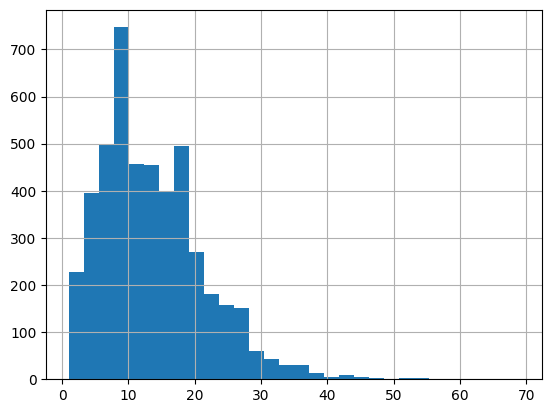

In [ ]:
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 30)
max_seq_len = max(seq_len)
print(max_seq_len)

In [ ]:
# tokenize and encode sequences in the training set
if max_seq_len>512:
    max_seq_len = 512
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)



In [ ]:
# for train set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())
print("train_y:",train_y)
# for validation set
val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())
print("val_y:",val_y)


train_y: tensor([0, 0, 0,  ..., 7, 7, 7])
val_y: tensor([5, 0, 7,  ..., 0, 5, 5])


In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 16

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [ ]:
# freeze all the parameters
for param in bert.parameters():
    param.requires_grad = False

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert, num_classes):
        super(BERT_Arch, self).__init__()
        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.1)

        # relu activation function
        self.relu =  nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 512)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(512, num_classes)

        #softmax activation function
        self.softmax = nn.LogSoftmax(dim=1)

        #define the forward pass
    def forward(self, sent_id, mask):

        #pass the inputs to the model
        _, cls_hs = self.bert(sent_id, attention_mask=mask, return_dict=False)

        x = self.fc1(cls_hs)

        x = self.relu(x)

        x = self.dropout(x)

        # output layer
        x = self.fc2(x)

        # apply softmax activation
        x = self.softmax(x)
        return x

In [ ]:
# pass the pre-trained BERT to our define architecture
model = BERT_Arch(bert, len(person_vectors))

# push the model to GPU
model = model.to(device)

In [ ]:
# optimizer from hugging face transformers
from transformers import AdamW

# define the optimizer
optimizer = AdamW(model.parameters(), lr = 1e-3)

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
class_wts = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)

print(class_wts)

[0.72971698 0.94482899 1.00891304 0.6898038  1.46867089 1.31547619
 1.4576005  0.99677835]


In [ ]:
# convert class weights to tensor
weights= torch.tensor(class_wts,dtype=torch.float)
weights = weights.to(device)

# loss function
cross_entropy  = nn.NLLLoss(weight=weights)

# number of training epochs
epochs = 400

In [ ]:
# function to train the model
def train():
    model.train()

    total_loss, total_accuracy = 0, 0

    # empty list to save model predictions
    total_preds=[]
    total_labels =[]

    # iterate over batches
    for step,batch in enumerate(train_dataloader):

        # progress update after every 50 batches.
        if step % 100 == 0 and not step == 0:
            print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))

        # push the batch to gpu
        batch = [r.to(device) for r in batch]

        sent_id, mask, labels = batch

        # clear previously calculated gradients
        model.zero_grad()

        # get model predictions for the current batch
        preds = model(sent_id, mask)

        # compute the loss between actual and predicted values
        loss = cross_entropy(preds, labels)

        # add on to the total loss
        total_loss = total_loss + loss.item()

        # backward pass to calculate the gradients
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # update parameters
        optimizer.step()

        # model predictions are stored on GPU. So, push it to CPU
        preds = preds.detach().cpu().numpy()
        preds = np.argmax(preds, axis=1)
        # append the model predictions
        total_preds+=list(preds)
        total_labels+=labels.tolist()

    # compute the training loss of the epoch
    avg_loss = total_loss / len(train_dataloader)

    # predictions are in the form of (no. of batches, size of batch, no. of classes).
    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)
    f1 = f1_score(total_labels, total_preds, average='weighted')
    #returns the loss and predictions
    return avg_loss, f1

In [ ]:
# function for evaluating the model
def evaluate():

    print("\nEvaluating...")

    # deactivate dropout layers
    model.eval()

    total_loss, total_accuracy = 0, 0

    # empty list to save the model predictions
    total_preds = []
    total_labels = []
    # iterate over batches
    for step,batch in enumerate(val_dataloader):

        # Progress update every 50 batches.
        if step % 50 == 0 and not step == 0:

          # Calculate elapsed time in minutes.
          #elapsed = format_time(time.time() - t0)

          # Report progress.
          print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

        # push the batch to gpu
        batch = [t.to(device) for t in batch]

        sent_id, mask, labels = batch

        # deactivate autograd
        with torch.no_grad():

            # model predictions
            preds = model(sent_id, mask)

            # compute the validation loss between actual and predicted values
            loss = cross_entropy(preds,labels)

            total_loss = total_loss + loss.item()

            preds = preds.detach().cpu().numpy()
            preds = np.argmax(preds, axis=1)
            total_preds+=list(preds)
            total_labels+=labels.tolist()
    # compute the validation loss of the epoch
    avg_loss = total_loss / len(val_dataloader)

    # reshape the predictions in form of (number of samples, no. of classes)
    #total_preds  = np.concatenate(total_preds, axis=0)

    f1 = f1_score(total_labels, total_preds, average='weighted')
    return avg_loss, f1

In [ ]:
def save_checkpoint(filename, epoch, model, optimizer, label_map, id2label):
    state = {
        'epoch': epoch,
        'model': model,
        'optimizer': optimizer,
        'label_map': label_map,
        'id_map':id2label}
    torch.save(state, filename)

In [ ]:
# set initial loss to infinite
best_train_loss = float('inf')
best_val_loss = float('inf')

# empty lists to store training and validation loss of each epoch
train_losses=[]
valid_losses=[]

#for each epoch
for epoch in range(epochs):

    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))

    #train model
    train_loss, f1_train = train()

    #evaluate model
    valid_loss, f1_valid = evaluate()

    #save the best model
    if train_loss < best_train_loss:
        best_train_loss = train_loss
        file_name = 'drive/MyDrive/BERT/model_weights.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)

    if valid_loss < best_val_loss:
        best_val_loss = valid_loss
        file_name = 'drive/MyDrive/BERT/model_weights_val.pt'
        save_checkpoint(file_name, epoch, model, optimizer, label_map, id2label)

    # append training and validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')
    print(f'\nTraining F1: {f1_train:.3f}')
    print(f'Validation F1: {f1_valid:.3f}')

Выходные данные были обрезаны до нескольких последних строк (5000).
Evaluating...
  Batch    50  of     75.

Training Loss: 1.605
Validation Loss: 1.507

Training F1: 0.407
Validation F1: 0.516

 Epoch 17 / 400
  Batch   100  of    291.
  Batch   200  of    291.

Evaluating...
  Batch    50  of     75.

Training Loss: 1.591
Validation Loss: 1.499

Training F1: 0.411
Validation F1: 0.510

 Epoch 18 / 400
  Batch   100  of    291.
  Batch   200  of    291.

Evaluating...
  Batch    50  of     75.

Training Loss: 1.553
Validation Loss: 1.485

Training F1: 0.425
Validation F1: 0.539

 Epoch 19 / 400
  Batch   100  of    291.
  Batch   200  of    291.

Evaluating...
  Batch    50  of     75.

Training Loss: 1.546
Validation Loss: 1.411

Training F1: 0.431
Validation F1: 0.549

 Epoch 20 / 400
  Batch   100  of    291.
  Batch   200  of    291.

Evaluating...
  Batch    50  of     75.

Training Loss: 1.528
Validation Loss: 1.477

Training F1: 0.429
Validation F1: 0.546

 Epoch 21 / 400
  Bat

In [ ]:
path = 'drive/MyDrive/BERT/model_weights.pt'

checkpoint = torch.load(path, map_location=device)
model = checkpoint.get("model")
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base')


# tokenize and encode sequences in the test set
test_text = []; test_labels = []

# Загружаем описание личности человека для каждого вектора из книги М.В. Бородянского
for person_vector in person_vectors:
    with open("drive/MyDrive/vectors_/" + person_vector + ".txt", encoding="utf8") as rf:
        for sentence in split_text(rf.read().strip()):
            if len(sentence) <= 2: continue
            test_text.append(sentence)
            test_labels.append(person_vectors.index(person_vector))

test_text = np.array(test_text)
test_labels = np.array(test_labels)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())
print("test_y:",test_y)

test_y: tensor([0, 0, 0,  ..., 7, 7, 7])


In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.96      0.98      0.97       396
           1       0.97      0.98      0.97       299
           2       0.99      0.95      0.97       369
           3       0.98      0.94      0.96       317
           4       0.97      0.99      0.98       232
           5       0.96      1.00      0.98       252
           6       0.99      0.99      0.99       192
           7       0.98      1.00      0.99       252

    accuracy                           0.97      2309
   macro avg       0.98      0.98      0.98      2309
weighted avg       0.98      0.97      0.97      2309



In [ ]:
class Prediction:
    def __init__(self):
        path = 'drive/MyDrive/BERT/model_weights.pt'

        checkpoint = torch.load(path,map_location=device)
        self.predictor = checkpoint.get("model")
        self.tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base')
        self.tag = checkpoint.get("id_map")

    def predict(self,text):
        tokens = self.tokenizer.tokenize(text)
        tokens = tokens[:max_seq_len - 2]
        tokens = ['[CLS]'] + tokens + ['[SEP]']

        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)
        input_ids = input_ids + [0] * (max_seq_len-len(input_ids))
        input_ids = torch.tensor(input_ids).unsqueeze(0)
        input_ids = input_ids.to(device)

        input_mask = [1]*len(tokens) + [0] * (max_seq_len - len(tokens))
        input_mask = torch.tensor(input_mask).unsqueeze(0)
        input_mask = input_mask.to(device)

        logits = self.predictor(input_ids,input_mask)
        prob = torch.nn.functional.softmax(logits,dim=1)
        result = [(self.tag[idx],item) for idx,item in enumerate(prob[0].tolist())]
        preds = logits.detach().cpu().numpy()
        pred_val = np.argmax(preds)
        pred_val = self.tag[pred_val]
        return result,pred_val


In [ ]:
pred = Prediction()

In [ ]:
text = []

with open("drive/MyDrive/val/Основы дзэн-буддизма.txt", encoding="utf8") as rf:
    for sentence in split_text(rf.read().strip()):
        if len(sentence) <= 5: continue
        text.append(sentence)

text[:30]

['Спасибо, что скачали книгу в бесплатной электронной библиотеке Royallib',
 'ru\nВсе книги автора\nЭта же книга в других форматах\n\nПриятного чтения',
 'Дайсэцу Тайтаро Судзуки\nОсновы дзэнбуддизма\n\nКРАТКО ОБ АВТОРЕ\n\nДзэнбуддизм в последние годы вызывает к себе самый живой интерес как в Америке, так и в Европе',
 'Пробуждению на Западе такого интереса к одной из наиболее древних и глубоких религий Востока в значительной мере способствовал автор данной книги Дайсэцу Тайтаро Судзуки',
 'Он является самым прославленным и красноречивым толкователем дзэна на земном шаре',
 'Судзуки сначала преподавал в нескольких ведущих университетах Японии, а затем расширил свою деятельность, перенеся ее за рамки отечества и развивая в международном масштабе',
 'Начиная с посещения Великобритании в 1936 году в качестве преподавателя (по обмену), он затем читал лекции в различных университетах Америки и Европы',
 'Он также написал более ста работ о дзэне и буддизме как на японском, так и на английско

In [ ]:
list_input = ['Такие люди обладают ясновидением, точнее яснослышанием.']

for item in list_input:
    confidence,pred_val = pred.predict(item)
    print(pred_val)
    print(confidence)

blue
[('brown', 0.0002236814034404233), ('black', 0.028900807723402977), ('red', 0.0013563736574724317), ('orange', 0.0008247167570516467), ('yellow', 9.238251368515193e-05), ('green', 0.0006321947439573705), ('blue', 0.9646031856536865), ('purple', 0.003366561373695731)]


In [ ]:
path = 'drive/MyDrive/BERT/model_weights.pt'

checkpoint = torch.load(path, map_location=device)
model = checkpoint.get("model")
tokenizer = BertTokenizer.from_pretrained('sberbank-ai/ruBert-base')


# tokenize and encode sequences in the test set
test_text = []

with open("drive/MyDrive/val/Гамлет, принц Датский - Уильям Шекспир.txt", encoding="utf8") as rf:
    for text in rf.readlines():
        for sentence in split_text(text):
            if len(sentence) <= 5: continue
            test_text.append(sentence.strip())

test_text = np.array(test_text)

tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = max_seq_len,
    pad_to_max_length=True,
    truncation=True,
    return_token_type_ids=False
)

# for test set
test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])

FileNotFoundError: ignored

In [ ]:
# get predictions for test data
with torch.no_grad():
    preds = model(test_seq.to(device), test_mask.to(device))
    preds = preds.detach().cpu().numpy()

In [ ]:
preds = np.argmax(preds, axis = 1)

In [ ]:
for vectorId in range(len(person_vectors)):
    prob = (preds == vectorId).sum() / len(preds)
    print(person_vectors[vectorId], prob)